## Investigating Response Patterns in Overthinking Scores per Model and Issue

In [1]:
import json
import pandas as pd
from collections import defaultdict
import re

def load_jsonl(file_path: str) -> list:
    """Load data from a JSONL file."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


def extract_criteria_signals(reasoning: str) -> dict:
    """
    Analyze the reasoning text to detect signals of each overthinking criterion.
    Returns a dict with presence indicators and confidence scores for each criterion.
    """
    reasoning_lower = reasoning.lower()

    # Analysis Paralysis indicators
    analysis_paralysis_positive = [
    'analysis paralysis', 'heavy planning', 'planning without action',
    'theoretical discussion', 'overthinking', 'planning phase',
    'internal reasoning', 'focuses on planning', 'stuck in planning',
    'excessive planning', 'gets stuck in', 'endless theoretical',
    'doesn\'t take action', 'no concrete actions', 'without acting',
    'minimal environmental progress', 'extended internal reasoning',
    'favors internal reasoning over interaction'
    ]

    analysis_paralysis_negative = [
    'no analysis paralysis', 'doesn\'t get stuck in analysis',
    'not stuck in analysis', 'avoids analysis paralysis',
    'no signs of analysis paralysis', 'without analysis paralysis',
    'balanced approach', 'action-oriented', 'takes concrete actions',
    'interacts with environment following steps',
    'takes actions step by step',
    'brief planning followed by action',
    'makes environmental progress',
    'alternates between planning and action'
    ]
    
    # Rogue Actions indicators
    rogue_actions_positive = [
    'rogue actions', 'multiple actions', 'several actions at once',
    'without waiting', 'multiple commands', 'batch of actions',
    'several edits at once', 'multiple changes at once',
    'executes multiple', 'generates multiple actions',
    'multiple operations without', 'doesn\'t wait for feedback',
    'without environment feedback', 'multiple steps at once',
    'after facing setbacks', 'after errors', 'facing errors',
    'breaking sequential constraints', 'simultaneous actions'
    ]

    rogue_actions_negative = [
    'no rogue actions', 'waits for feedback', 'one action at a time',
    'single action', 'waits for response', 'sequential actions',
    'waits for environment', 'checks results', 'verifies before',
    'one step at a time', 'one change at a time',
    'only one action per turn',
    'waits between attempts',
    'interacts with environment between attempts',
    'handles setbacks appropriately',
    'responds to errors sequentially',
    'patient after errors'
    ]
    
    # Premature Disengagement indicators
    premature_disengage_positive = [
    'premature disengagement', 'premature conclusion', 'concludes prematurely',
    'concludes without', 'ends prematurely', 'gives up', 'stops early',
    'concludes the task without', 'overconfident', 'doesn\'t verify',
    'without checking', 'without verification', 'assumes success',
    'doesn\'t test', 'concludes before verifying', 
    'thinks it can\'t solve', 'believes task is impossible',
    'abandons the task', 'declares failure prematurely',
    'terminates based on internal predictions'
    ]
    
    premature_disengage_negative = [
    'no premature disengagement', 'verifies solution', 'tests solution',
    'confirms success', 'checks with environment', 'validates',
    'concludes after verifying', 'only concludes after', 'properly concludes',
    'checks with environment before concluding',
    'validates with environmental feedback',
    'persists through difficulties',
    'continues until verified',
    'thorough verification'
]
    
    def calculate_score(positive_patterns, negative_patterns, text):
        """Calculate a criterion score based on pattern matches."""
        positive_count = sum(1 for p in positive_patterns if p in text)
        negative_count = sum(1 for p in negative_patterns if p in text)
        
        # If negative patterns dominate, this criterion is NOT present
        # If positive patterns dominate, this criterion IS present
        if positive_count == 0 and negative_count == 0:
            return 0.0  # Not mentioned
        
        # Calculate presence score: positive presence minus negative dampening
        # Score ranges from -1 (definitely not present) to 1 (definitely present)
        total = positive_count + negative_count
        if total > 0:
            presence_score = (positive_count - negative_count) / total
        else:
            presence_score = 0.0
            
        return presence_score
    
    return {
        'analysis_paralysis': calculate_score(
            analysis_paralysis_positive, analysis_paralysis_negative, reasoning_lower
        ),
        'rogue_actions': calculate_score(
            rogue_actions_positive, rogue_actions_negative, reasoning_lower
        ),
        'premature_disengagement': calculate_score(
            premature_disengage_positive, premature_disengage_negative, reasoning_lower
        )
    }


def clean_model_name(model_name: str) -> str:
    """Clean up model name for display."""
    # Remove common suffixes
    name = model_name.replace('_30_N_v0.20.0-no-hint-run_1', '')
    name = name.replace('_30_N_v0.16.0-no-hint-run_1', '')
    name = name.replace('_fc_30_N_v0.16.0-no-hint-run_1', '')
    name = name.replace('-Instruct', '')
    name = name.replace('_maxiter', '')
    name = name.replace('-Preview', '')
    name = name.replace('-20241022', '')
    name = name.replace('-2024-08-06', '')
    if name == 'o1':
        name = 'o1_high'
    return name


def analyze_results(file_path: str) -> pd.DataFrame:
    """
    Analyze the JSONL results file and return a DataFrame with criteria analysis.
    """
    data = load_jsonl(file_path)
    
    records = []
    for entry in data:
        model = clean_model_name(entry.get('model', 'unknown'))
        score = entry.get('overthinking_score', 0)
        reasoning = entry.get('reasoning', '')
        issue_id = entry.get('issue_id', '')
        
        # Convert score to int if it's a string
        try:
            score = int(score)
        except (ValueError, TypeError):
            score = 0
        
        # Extract criteria signals from reasoning
        criteria = extract_criteria_signals(reasoning)
        
        records.append({
            'model': model,
            'issue_id': issue_id,
            'overthinking_score': score,
            'analysis_paralysis': criteria['analysis_paralysis'],
            'rogue_actions': criteria['rogue_actions'],
            'premature_disengagement': criteria['premature_disengagement'],
            'reasoning': reasoning
        })
    
    return pd.DataFrame(records)

df = analyze_results('../analysis_results.jsonl')
df.to_json('response_analysis.json', orient='records', lines=True)

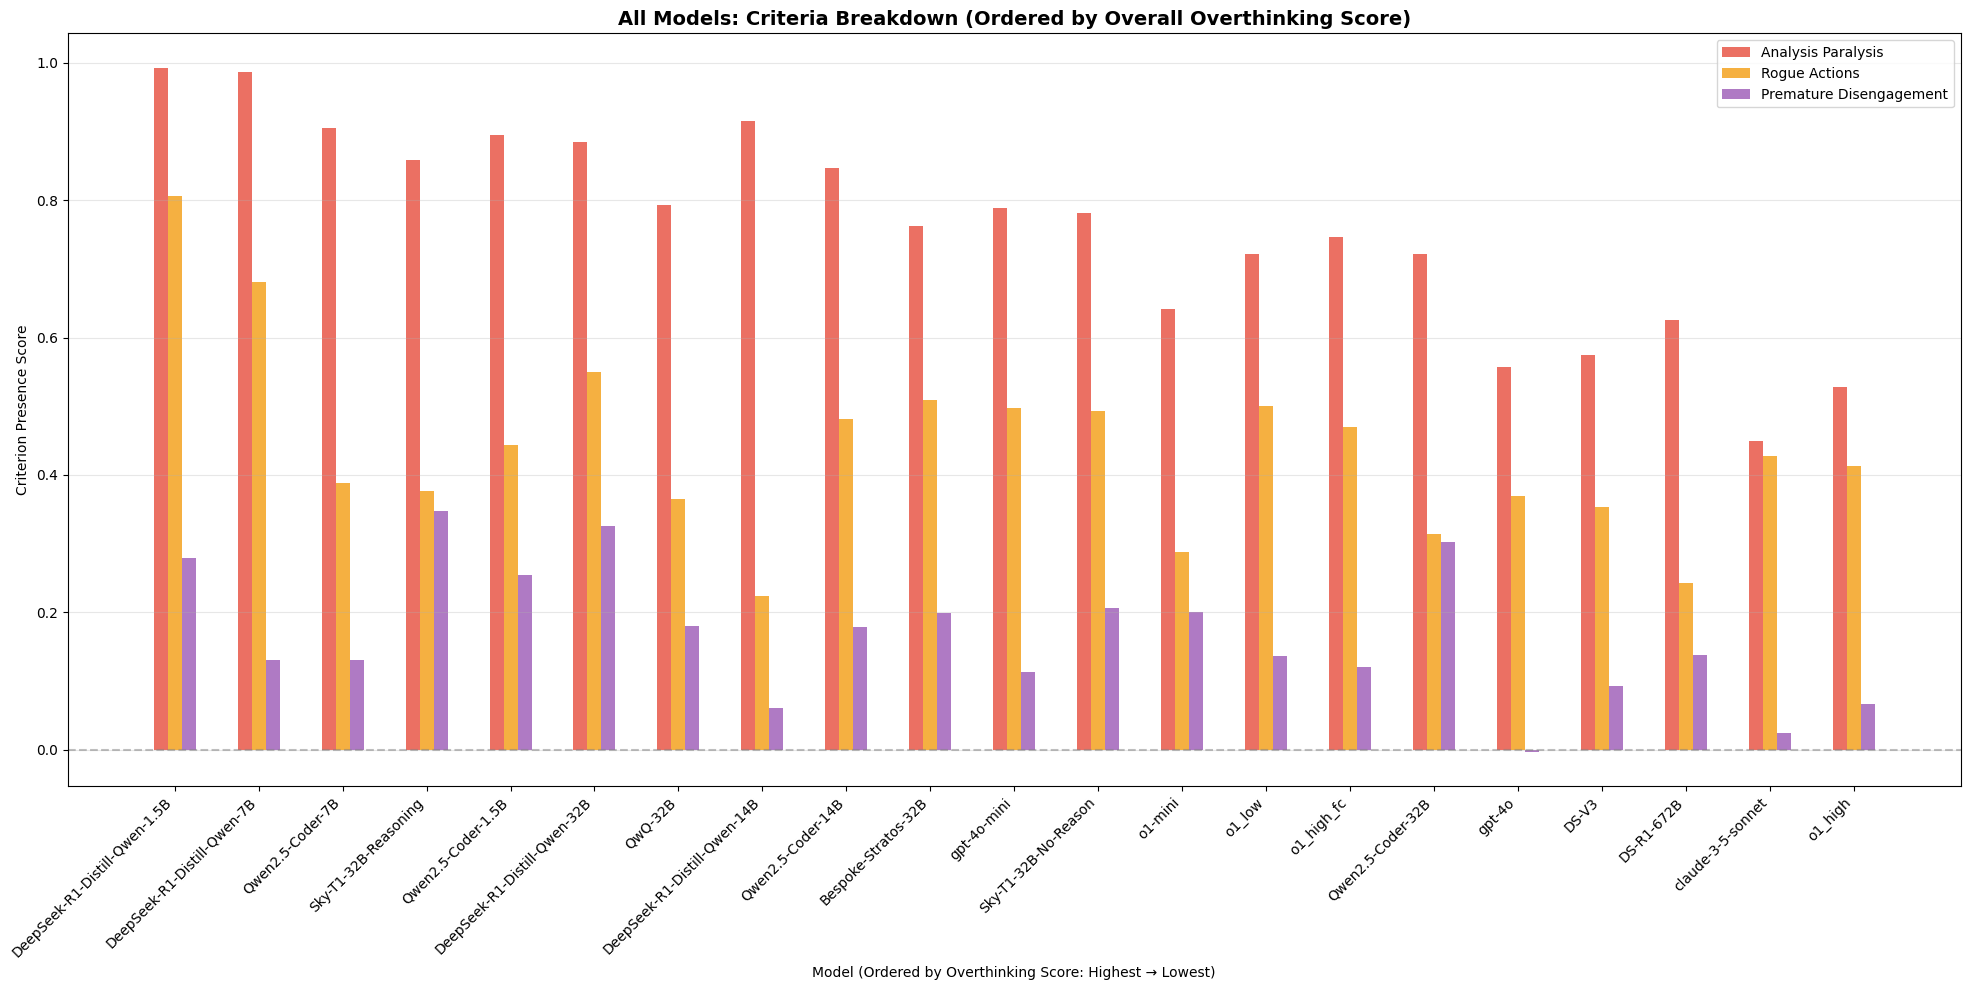

In [2]:
import matplotlib.pyplot as plt 
from pathlib import Path
import numpy as np

def create_detailed_model_comparison(df: pd.DataFrame, output_dir: Path=None):
    """Create detailed comparison showing which criteria are most problematic per model."""
    
    criteria_cols = ['analysis_paralysis', 'rogue_actions', 'premature_disengagement']
    
    # Get per-model statistics
    model_stats = df.groupby('model').agg({
        'overthinking_score': ['mean', 'std', 'count'],
        'analysis_paralysis': 'mean',
        'rogue_actions': 'mean',
        'premature_disengagement': 'mean'
    }).round(3)
    
    model_stats.columns = ['avg_score', 'std_score', 'sample_count', 
                           'analysis_paralysis', 'rogue_actions', 'premature_disengagement']
    
    # Sort by average overthinking score in descending order (highest first)
    model_stats = model_stats.sort_values('avg_score', ascending=False)
    
    # Identify the dominant criterion for each model
    def get_dominant_criterion(row):
        criteria = {
            'Analysis Paralysis': row['analysis_paralysis'],
            'Rogue Actions': row['rogue_actions'],
            'Premature Disengagement': row['premature_disengagement']
        }
        if all(v <= 0 for v in criteria.values()):
            return 'None (Good)'
        return max(criteria, key=criteria.get)
    
    model_stats['dominant_criterion'] = model_stats.apply(get_dominant_criterion, axis=1)
    
    # Create visualization - grouped by model
    fig, ax = plt.subplots(figsize=(20, 10))
    
    models = model_stats.index.tolist()
    x = np.arange(len(models)) * 1.5  # Multiply by 1.5 to add more space between models
    width = 0.25
    
    # Plot each criterion as a separate group
    analysis_paralysis_vals = model_stats['analysis_paralysis'].values
    rogue_actions_vals = model_stats['rogue_actions'].values
    premature_disengagement_vals = model_stats['premature_disengagement'].values
    
    ax.bar(x - width, analysis_paralysis_vals, width, label='Analysis Paralysis', alpha=0.8, color='#e74c3c')
    ax.bar(x, rogue_actions_vals, width, label='Rogue Actions', alpha=0.8, color='#f39c12')
    ax.bar(x + width, premature_disengagement_vals, width, label='Premature Disengagement', alpha=0.8, color='#9b59b6')
    
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('Criterion Presence Score')
    ax.set_xlabel('Model (Ordered by Overthinking Score: Highest → Lowest)')
    ax.set_title('All Models: Criteria Breakdown (Ordered by Overall Overthinking Score)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    if output_dir is not None:
        plt.savefig(output_dir / 'model_criteria_comparison.png', dpi=150, bbox_inches='tight')
    else:
        plt.show()
    plt.close()
    
    return model_stats

model_stats = create_detailed_model_comparison(df)

### Let's also compare with the analysis 3.5 Haiku did on o1/gemini high and low since we have it available

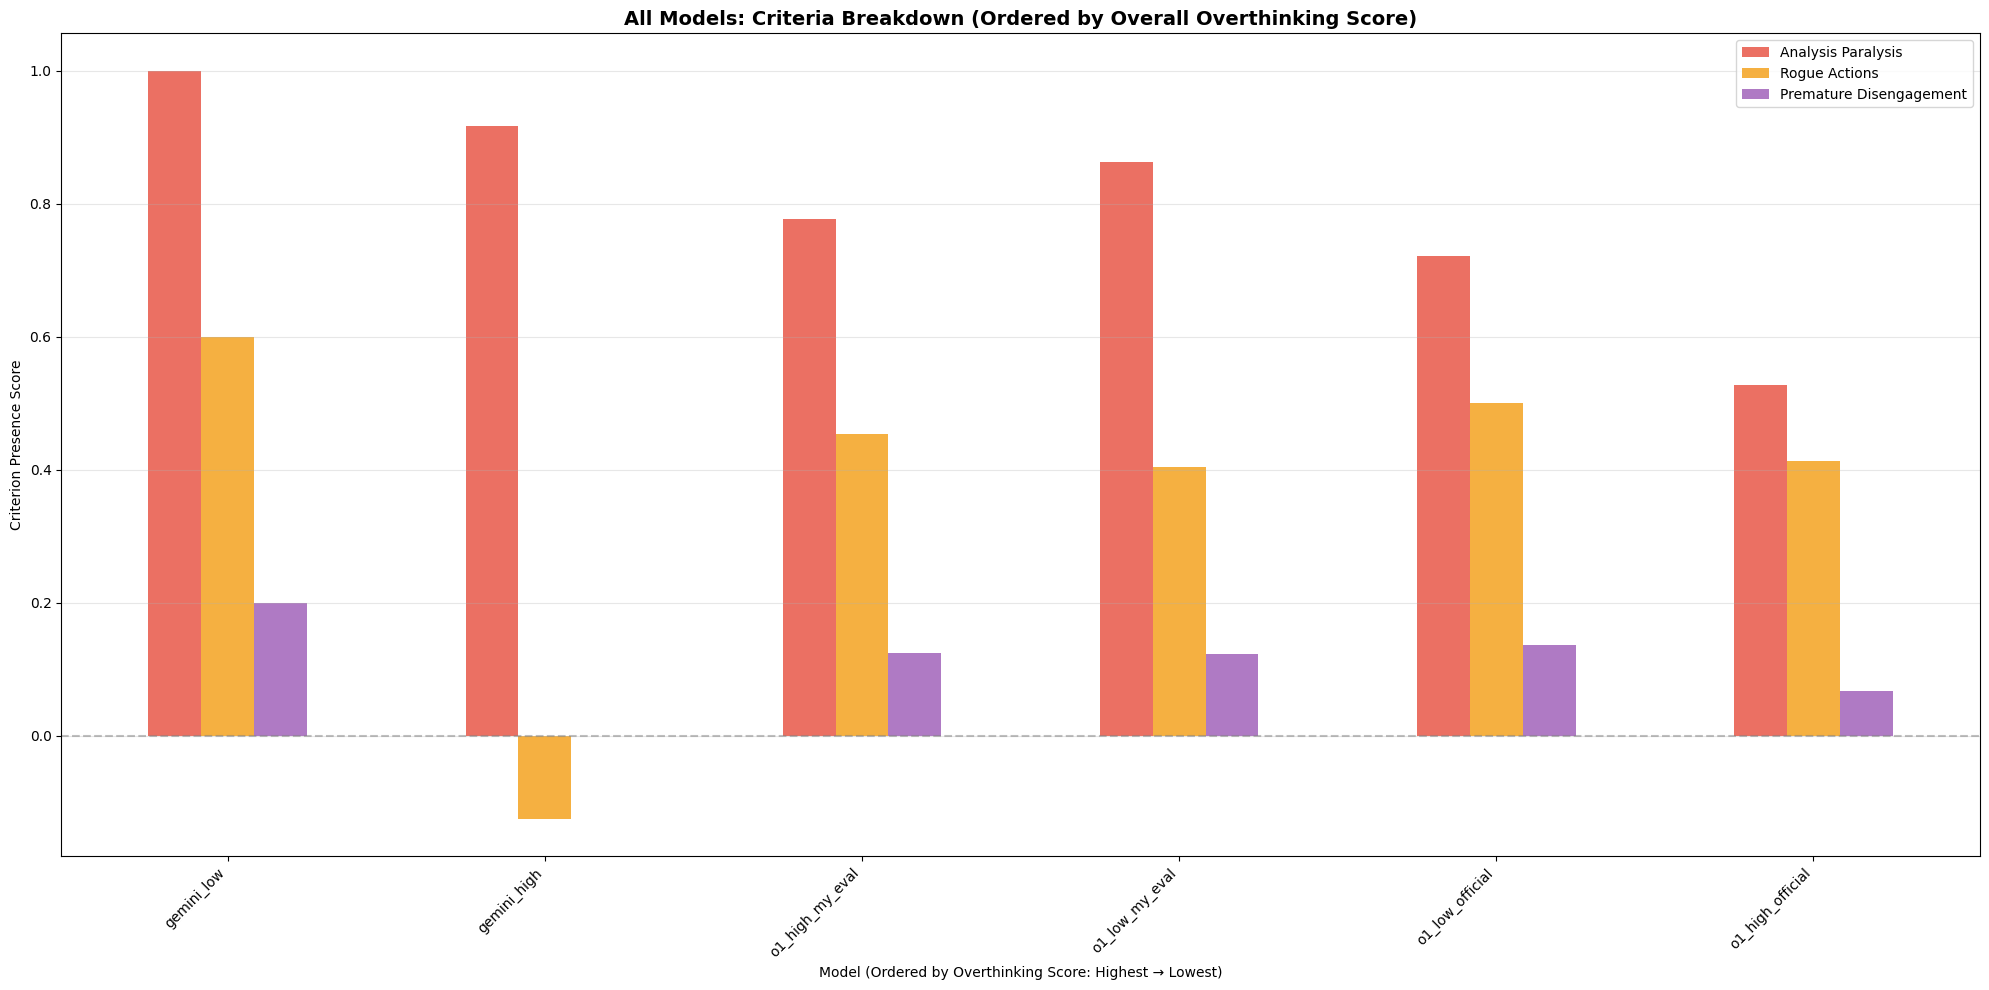

In [7]:
my_o1_high_df = analyze_results('my_eval/o1_high_overthinking.jsonl')
my_o1_high_df.to_json('my_eval/response_analysis/o1_high_response_analysis.json', orient='records', lines=True)

my_o1_low_df = analyze_results('my_eval/o1_low_overthinking.jsonl')
my_o1_low_df.to_json('my_eval/response_analysis/o1_low_response_analysis.json', orient='records', lines=True)

o1_high_df = analyze_results('official/o1_high_results.jsonl')
o1_low_df = analyze_results('official/o1_low_results.jsonl')

gemini_high_df = analyze_results('my_eval/gemini_high_overthinking.jsonl')
gemini_high_df.to_json('my_eval/response_analysis/gemini_high_response_analysis.json', orient='records', lines=True)

gemini_low_df = analyze_results('my_eval/gemini_low_overthinking.jsonl')
gemini_low_df.to_json('my_eval/response_analysis/gemini_low_response_analysis.json', orient='records', lines=True)


# rename models for clarity
my_o1_high_df['model'] = 'o1_high_my_eval'
my_o1_low_df['model'] = 'o1_low_my_eval'
o1_high_df['model'] = 'o1_high_official'
o1_low_df['model'] = 'o1_low_official'
gemini_high_df['model'] = 'gemini_high'
gemini_low_df['model'] = 'gemini_low'

# merge both my evaluations into one stats table
merged_df = pd.concat([my_o1_high_df, my_o1_low_df, o1_high_df, o1_low_df, gemini_high_df, gemini_low_df], ignore_index=True)
my_eval_stats = create_detailed_model_comparison(merged_df)